# Import

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

PROJECT_DIR = os.path.join(os.path.dirname('lstm_model.ipynb'), os.pardir) + '/..'

In [2]:
# Reading the up-sampled dataset
up_train = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_train.csv', usecols=['Description', 'Accident Level'])
test = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_test.csv', usecols=['Description', 'Accident Level'])
up_train.head()

,Description,Accident Level
0,By manually moving a steel cabinet for disposa...,3
1,Once the mooring of the faneles in the detonat...,1
2,When performing cleaning activity of the area ...,3
3,The technician was doing the magnetometric sur...,1
4,The operator cleaned with spatula spear throug...,1


# Word Cloud

In [3]:
# to generate a wordcloud
from wordcloud import WordCloud

def display_wordcloud(series):
    # Generating wordcloud
    word_cloud = WordCloud(width = 1000, height = 600, background_color ='white', min_font_size = 10)
    word_cloud.generate(' '.join(list(series.apply(lambda x: x.lower()))))

    # plot the WordCloud image                       
    plt.figure(figsize=(6, 6), facecolor = None)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show();

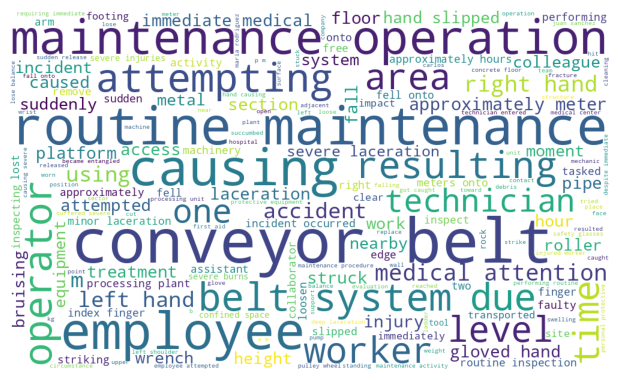

In [4]:
display_wordcloud(up_train['Description'])

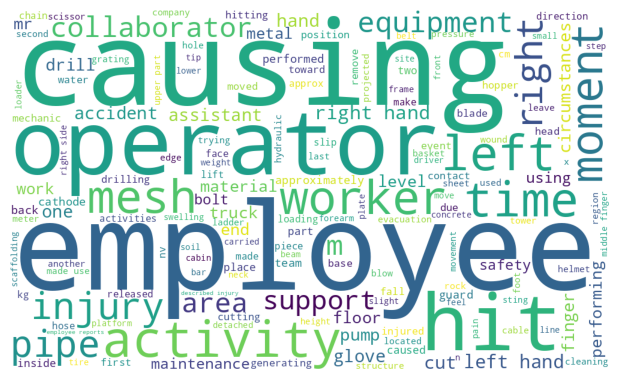

In [5]:
display_wordcloud(test['Description'])

# Tokenization

In [6]:
# Splitting features and targets
x_train = up_train['Description'].str.strip()
y_train = up_train['Accident Level']

x_test = test['Description'].str.strip()
y_test = test['Accident Level']

In [7]:
from tensorflow.keras.layers import TextVectorization

tokenizer = TextVectorization(
    max_tokens=5000,
    output_mode='int',
    standardize='lower_and_strip_punctuation',
)
tokenizer.adapt(x_train)
print('Vocabulary size:', tokenizer.vocabulary_size())
tokenizer.get_vocabulary()

Vocabulary size: 4839


['',
 '[UNK]',
 'the',
 'a',
 'of',
 'to',
 'and',
 'on',
 'in',
 'at',
 'was',
 'his',
 'an',
 'during',
 'maintenance',
 'he',
 'with',
 'causing',
 'from',
 'belt',
 'when',
 'conveyor',
 'as',
 'approximately',
 'routine',
 'hand',
 'while',
 'left',
 'by',
 'for',
 'that',
 'employee',
 'right',
 'area',
 'system',
 'it',
 'severe',
 'operator',
 'medical',
 'onto',
 'operation',
 'level',
 'due',
 'lacerations',
 'caused',
 'him',
 'metal',
 'meters',
 'attempting',
 'resulting',
 'between',
 'technician',
 'worker',
 'equipment',
 'slipped',
 'floor',
 'injuries',
 'bruising',
 'attempted',
 'using',
 'hours',
 'occurred',
 'suddenly',
 'one',
 'their',
 'were',
 'moving',
 'time',
 'sudden',
 'fell',
 'nearby',
 'performing',
 'attention',
 'minor',
 'am',
 'two',
 'accident',
 'injury',
 'safety',
 'activity',
 'into',
 'her',
 '3',
 'fall',
 'which',
 'incident',
 'processing',
 'is',
 'immediate',
 'but',
 'access',
 'pipe',
 'force',
 'finger',
 'section',
 'height',
 'arm'

# Label, One-hot Encoding

In [8]:
# Label encoding to ensure the labels start from 0
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [9]:
# One-hot encoded vectors
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

y_train_ohe

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

# Model LSTM

In [10]:
from tensorflow import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, GlobalMaxPool1D, Dropout

In [11]:
# Loading pre-trained GloVe word embeddings
EMBEDDING_SIZE = 200
embeddings_dictionary = dict()

glove_file = open(f'{PROJECT_DIR}/models/glove.6B.200d/glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [12]:
# Embedding matrix for Descriptions
embedding_matrix = np.zeros((tokenizer.vocabulary_size(), EMBEDDING_SIZE))

for i, word in enumerate(tokenizer.get_vocabulary()):
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
def build_lstm():
    model = Sequential()
    model.add(Input(shape=(1,), dtype=string))
    
    model.add(tokenizer)
    model.add(Embedding(
        input_dim=tokenizer.vocabulary_size(),
        output_dim=EMBEDDING_SIZE,
        weights=[embedding_matrix],
        trainable=False
    ))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5, input_shape=(256,)))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5, input_shape=(128,)))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5, input_shape=(64,)))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5, input_shape=(32,)))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5, input_shape=(16,)))

    model.add(Dense(5, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(learning_rate=0.001), 
        metrics=['accuracy', Recall(), Precision()]
    )

    return model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks = [
    EarlyStopping(monitor='loss', patience=10, min_delta=1e-2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1e-6, verbose=1),
    ModelCheckpoint(PROJECT_DIR + '/models/lstm', monitor='val_loss', save_best_only=True, initial_value_threshold=1, verbose=1),
    TensorBoard(log_dir=f'{PROJECT_DIR}/reports/tensorboard/')
]

In [15]:
lstm = build_lstm()
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 200)         967800    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        336896    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [16]:
history = lstm.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), batch_size=10, epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
114/116 [============================>.] - ETA: 0s - loss: 1.6736 - accuracy: 0.2000 - recall: 0.0053 - precision: 0.1765
Epoch 1: val_loss did not improve from 1.00000
116/116 [==============================] - 17s 56ms/step - loss: 1.6731 - accuracy: 0.2017 - recall: 0.0052 - precision: 0.1765 - val_loss: 1.6128 - val_accuracy: 0.0952 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 1.6213 - accuracy: 0.2225 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2: val_loss did not improve from 1.00000
116/116 [==============================] - 4s 31ms/step - loss: 1.6213 - accuracy: 0.2225 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.6113 - val_accuracy: 0.0952 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 3/100
115/116 [============================>.] - ETA: 0s - loss: 1.6149 - accuracy: 0.2217 - recall: 0.0026 - precision: 0.6000
Epoch 3: val_loss

INFO:tensorflow:Assets written to: ../../models\lstm\assets


INFO:tensorflow:Assets written to: ../../models\lstm\assets


116/116 [==============================] - 18s 157ms/step - loss: 0.9223 - accuracy: 0.5905 - recall: 0.3022 - precision: 0.8310 - val_loss: 0.9888 - val_accuracy: 0.7429 - val_recall: 0.7238 - val_precision: 0.7525 - lr: 0.0010
Epoch 29/100
115/116 [============================>.] - ETA: 0s - loss: 0.9270 - accuracy: 0.5739 - recall: 0.2878 - precision: 0.8275
Epoch 29: val_loss did not improve from 0.98875
116/116 [==============================] - 4s 32ms/step - loss: 0.9275 - accuracy: 0.5723 - recall: 0.2866 - precision: 0.8275 - val_loss: 0.9998 - val_accuracy: 0.7333 - val_recall: 0.7048 - val_precision: 0.7255 - lr: 0.0010
Epoch 30/100
116/116 [==============================] - ETA: 0s - loss: 0.9305 - accuracy: 0.5861 - recall: 0.3022 - precision: 0.8135
Epoch 30: val_loss improved from 0.98875 to 0.98239, saving model to ../../models\lstm


INFO:tensorflow:Assets written to: ../../models\lstm\assets


INFO:tensorflow:Assets written to: ../../models\lstm\assets


116/116 [==============================] - 17s 147ms/step - loss: 0.9305 - accuracy: 0.5861 - recall: 0.3022 - precision: 0.8135 - val_loss: 0.9824 - val_accuracy: 0.7429 - val_recall: 0.7333 - val_precision: 0.7404 - lr: 0.0010
Epoch 31/100
116/116 [==============================] - ETA: 0s - loss: 0.8882 - accuracy: 0.6000 - recall: 0.3004 - precision: 0.8321
Epoch 31: val_loss did not improve from 0.98239
116/116 [==============================] - 4s 32ms/step - loss: 0.8882 - accuracy: 0.6000 - recall: 0.3004 - precision: 0.8321 - val_loss: 1.0079 - val_accuracy: 0.7238 - val_recall: 0.7048 - val_precision: 0.7400 - lr: 0.0010
Epoch 32/100
114/116 [============================>.] - ETA: 0s - loss: 0.9259 - accuracy: 0.5851 - recall: 0.3114 - precision: 0.8161
Epoch 32: val_loss did not improve from 0.98239
116/116 [==============================] - 4s 33ms/step - loss: 0.9261 - accuracy: 0.5844 - recall: 0.3117 - precision: 0.8126 - val_loss: 0.9922 - val_accuracy: 0.7143 - val_rec

INFO:tensorflow:Assets written to: ../../models\lstm\assets


INFO:tensorflow:Assets written to: ../../models\lstm\assets


116/116 [==============================] - 20s 171ms/step - loss: 0.8454 - accuracy: 0.6277 - recall: 0.3758 - precision: 0.8645 - val_loss: 0.9775 - val_accuracy: 0.7333 - val_recall: 0.7048 - val_precision: 0.7475 - lr: 0.0010
Epoch 36/100
115/116 [============================>.] - ETA: 0s - loss: 0.8373 - accuracy: 0.6278 - recall: 0.3417 - precision: 0.8362
Epoch 36: val_loss did not improve from 0.97749
116/116 [==============================] - 4s 32ms/step - loss: 0.8360 - accuracy: 0.6286 - recall: 0.3429 - precision: 0.8372 - val_loss: 0.9965 - val_accuracy: 0.7333 - val_recall: 0.6952 - val_precision: 0.7604 - lr: 0.0010
Epoch 37/100
116/116 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.6017 - recall: 0.3688 - precision: 0.8272
Epoch 37: val_loss improved from 0.97749 to 0.95135, saving model to ../../models\lstm


INFO:tensorflow:Assets written to: ../../models\lstm\assets


INFO:tensorflow:Assets written to: ../../models\lstm\assets


116/116 [==============================] - 17s 150ms/step - loss: 0.8685 - accuracy: 0.6017 - recall: 0.3688 - precision: 0.8272 - val_loss: 0.9513 - val_accuracy: 0.7333 - val_recall: 0.7143 - val_precision: 0.7732 - lr: 0.0010
Epoch 38/100
116/116 [==============================] - ETA: 0s - loss: 0.8435 - accuracy: 0.6268 - recall: 0.3775 - precision: 0.8226
Epoch 38: val_loss did not improve from 0.95135
116/116 [==============================] - 4s 32ms/step - loss: 0.8435 - accuracy: 0.6268 - recall: 0.3775 - precision: 0.8226 - val_loss: 0.9762 - val_accuracy: 0.7143 - val_recall: 0.6762 - val_precision: 0.7474 - lr: 0.0010
Epoch 39/100
116/116 [==============================] - ETA: 0s - loss: 0.7959 - accuracy: 0.6511 - recall: 0.4338 - precision: 0.8200
Epoch 39: val_loss improved from 0.95135 to 0.92831, saving model to ../../models\lstm


INFO:tensorflow:Assets written to: ../../models\lstm\assets


INFO:tensorflow:Assets written to: ../../models\lstm\assets


116/116 [==============================] - 18s 155ms/step - loss: 0.7959 - accuracy: 0.6511 - recall: 0.4338 - precision: 0.8200 - val_loss: 0.9283 - val_accuracy: 0.7524 - val_recall: 0.7429 - val_precision: 0.7500 - lr: 0.0010
Epoch 40/100
116/116 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.6312 - recall: 0.4165 - precision: 0.8111
Epoch 40: val_loss improved from 0.92831 to 0.91936, saving model to ../../models\lstm


INFO:tensorflow:Assets written to: ../../models\lstm\assets


INFO:tensorflow:Assets written to: ../../models\lstm\assets


116/116 [==============================] - 18s 152ms/step - loss: 0.8412 - accuracy: 0.6312 - recall: 0.4165 - precision: 0.8111 - val_loss: 0.9194 - val_accuracy: 0.7524 - val_recall: 0.7429 - val_precision: 0.7573 - lr: 0.0010
Epoch 41/100
116/116 [==============================] - ETA: 0s - loss: 0.8074 - accuracy: 0.6355 - recall: 0.4268 - precision: 0.8149
Epoch 41: val_loss did not improve from 0.91936
116/116 [==============================] - 4s 33ms/step - loss: 0.8074 - accuracy: 0.6355 - recall: 0.4268 - precision: 0.8149 - val_loss: 0.9680 - val_accuracy: 0.7238 - val_recall: 0.6952 - val_precision: 0.7526 - lr: 0.0010
Epoch 42/100
115/116 [============================>.] - ETA: 0s - loss: 0.8228 - accuracy: 0.6383 - recall: 0.4226 - precision: 0.7980
Epoch 42: val_loss did not improve from 0.91936
116/116 [==============================] - 4s 32ms/step - loss: 0.8222 - accuracy: 0.6381 - recall: 0.4225 - precision: 0.7987 - val_loss: 0.9367 - val_accuracy: 0.7524 - val_rec